In [2]:
# __pycache__ファイルを作成しないようにする。
import os
os.environ['PYTHONDONTWRITEBYTECODE'] = "1"

In [3]:
%cd /Users/naoki/git/Horse-Racing
import module as m
import module._class as c
import _dat
from environment.variables import *

/Users/naoki/git/Horse-Racing


In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
import datetime
import lightgbm as lgb
import optuna.integration.lightgbm as lgb_o
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from bs4 import BeautifulSoup
from itertools import combinations
from itertools import permutations
from urllib.request import urlopen

In [5]:
# race_results(=r.data_c)の作成
r = c.Results(_dat.race_results)
# 前処理
r.preprocessing()
# 馬の過去成績の追加
hr = c.HorseResults(_dat.horse_results)
r.merge_horse_results(hr)
# 5世代分の血統データの追加
p = c.Peds(_dat.ped_results)
p.encode()
r.merge_peds(p.peds_e)
# カテゴリ変数の処理
r.process_categorical()

100%|██████████| 542/542 [00:38<00:00, 14.15it/s]


In [6]:
# r.data_cをtrain, test, validの3種のデータに分割
train, test = m.split_data(r.data_c)
train, valid = m.split_data(train)

In [7]:
# train, validを説明変数と目的変数に分割
X_train = train.drop(['rank', 'date', '単勝'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date', '単勝'], axis=1)
y_valid = valid['rank']

In [8]:
# lgbm用のデータに変形する
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

In [9]:
# パラメータ設定1
params = {
    'objective': 'binary',
    'random_state': 100,
    'verbose':0
}

In [ ]:
# パラメータ設定2
lgb_clf_o = lgb_o.train(params,
                        lgb_train,
                        valid_sets=(lgb_train, lgb_valid),
                        verbose_eval=100,
                        early_stopping_rounds=10
                        )

In [ ]:
lgb_clf_o.params

In [10]:
params={'objective': 'binary',
        'random_state': 100,
        'feature_pre_filter': False,
        'lambda_l1': 5.289135433159377,
        'lambda_l2': 4.708795060836079,
        'num_leaves': 16,
        'feature_fraction': 0.4,
        'bagging_fraction': 1.0,
        'bagging_freq': 0,
        'min_child_samples': 20}

In [11]:
# r.data_cを学習用データと検証用データに分割する
train, test = m.split_data(r.data_c)
X_train = train.drop(['rank', 'date', '単勝'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [12]:
# lgbで実際に学習を行う
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.708795060836079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.708795060836079
[LightGBM] [Warning] lambda_l1 is set=5.289135433159377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.289135433159377


LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.4,
               feature_pre_filter=False, lambda_l1=5.289135433159377,
               lambda_l2=4.708795060836079, num_leaves=16, objective='binary',
               random_state=100)

In [13]:
# ModelEvaluator
me = c.ModelEvaluator(lgb_clf, ['_dat/pickle/overall/return_tables.pickle'])
display(me.feature_importance(X_test.drop(['単勝'], axis=1), n_display=50))

,features,importance
5,jockey_id,126
7,n_horses,74
6,年齢,57
9,賞金_5R,51
27,賞金_race_type_5R,42
116,interval,42
3,course_len,35
4,horse_id,31
10,着差_5R,31
99,賞金_race_type_allR,30


In [14]:
g_proper = m.gain(me.tansho_return_proper, X_test)
g_tansho = m.gain(me.tansho_return, X_test)
g_fukusho = m.gain(me.fukusho_return, X_test)
g_umatan = m.gain(me.umatan_box, X_test)
g_umaren = m.gain(me.umaren_box, X_test)
g_wide = m.gain(me.wide_box, X_test)
g_sanrentan = m.gain(me.sanrentan_box, X_test)
g_sanrenpuku = m.gain(me.sanrenpuku_box, X_test)
g_umaren_nagashi = m.gain(me.umaren_nagashi, X_test)
g_umatan_nagashi = m.gain(me.umatan_nagashi, X_test)
g_wide_nagashi = m.gain(me.wide_nagashi, X_test)
g_sanrentan_nagashi = m.gain(me.sanrentan_nagashi, X_test)

 67%|██████▋   | 67/100 [16:47<04:29,  8.17s/it] /Users/naoki/git/Horse-Racing/module/_class/ModelEvaluator.py:175: RuntimeWarning: invalid value encountered in double_scalars
  std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
/Users/naoki/git/Horse-Racing/module/_class/ModelEvaluator.py:178: RuntimeWarning: invalid value encountered in long_scalars
  return_rate = np.sum(return_list) / n_bets
 67%|██████▋   | 67/100 [11:47<02:04,  3.77s/it]/Users/naoki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/naoki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/naoki/.pyenv/versions/3.10.1/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid

In [41]:
print(X_test)

              枠番  馬番    斤量     単勝  course_len horse_id jockey_id  年齢  \
202009030610   6  11  55.0    3.0        20.0    16546        29   4   
202009030610   7  14  57.0    7.7        20.0    14911       119   4   
202009030610   2   3  57.0    5.7        20.0    13463        27   4   
202009030610   1   1  57.0   28.6        20.0     2944       131   7   
202009030610   3   5  57.0   25.7        20.0     5325       122   6   
...           ..  ..   ...    ...         ...      ...       ...  ..   
202106050612   8  13  54.0   68.1        25.0    21593       157   4   
202106050612   4   5  55.0   11.7        25.0    18537        68   4   
202106050612   6   9  53.0   48.9        25.0    25464        72   3   
202106050612   5   7  55.0  259.7        25.0    10604       138   6   
202106050612   6   8  57.0  312.8        25.0    20059        87   4   

              n_horses  着順_5R  ...  race_type_芝  race_type_ダート  race_type_障害  \
202009030610        16    3.2  ...            1        

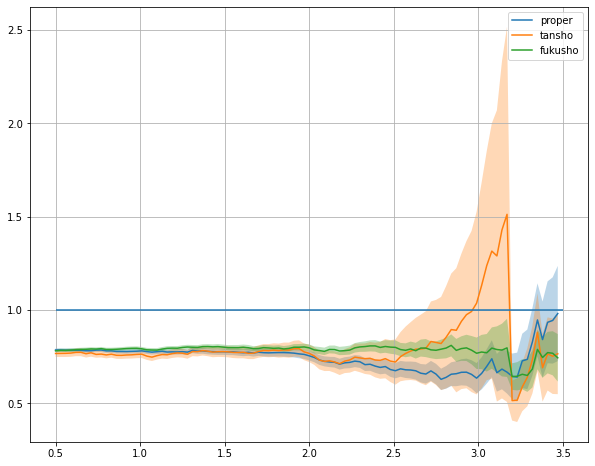

In [31]:
plt.figure(figsize=(10, 8))
m.plot(g_proper, 'proper')
m.plot(g_tansho, 'tansho')
m.plot(g_fukusho, 'fukusho')
plt.hlines(1, xmin=0.5, xmax=3.5) # y=1の直線

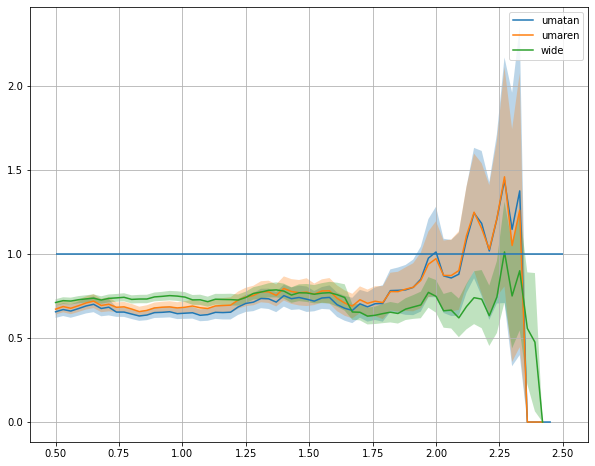

In [21]:
plt.figure(figsize=(10, 8))
m.plot(g_umatan, 'umatan')
m.plot(g_umaren, 'umaren')
m.plot(g_wide, 'wide')
plt.hlines(1, xmin=0.5, xmax=2.5) # y=1の直線

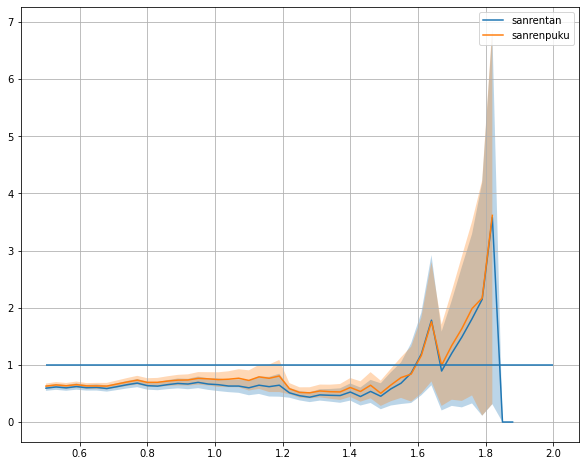

In [26]:
plt.figure(figsize=(10, 8))
m.plot(g_sanrentan, 'sanrentan')
m.plot(g_sanrenpuku, 'sanrenpuku')
plt.hlines(1, xmin=0.5, xmax=2.0) # y=1の直線

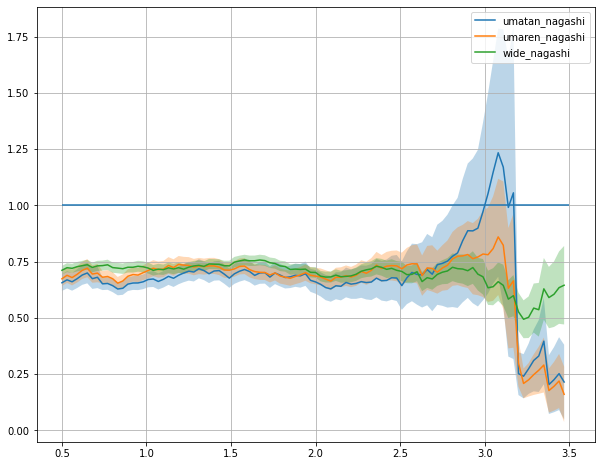

In [30]:
plt.figure(figsize=(10, 8))
m.plot(g_umatan_nagashi, 'umatan_nagashi')
m.plot(g_umaren_nagashi, 'umaren_nagashi')
m.plot(g_wide_nagashi, 'wide_nagashi')
plt.hlines(1, xmin=0.5, xmax=3.5) # y=1の直線

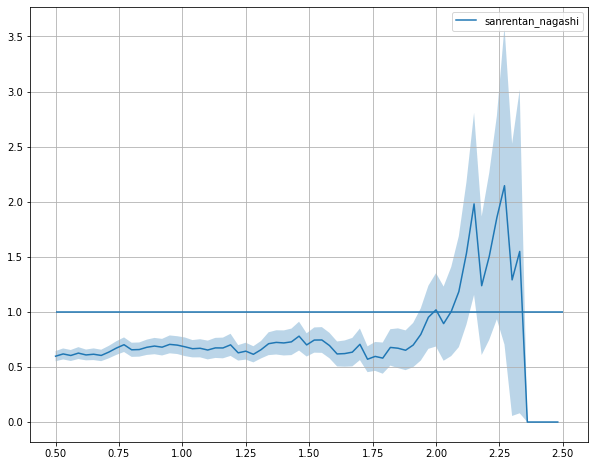

In [28]:
plt.figure(figsize=(10, 8))
m.plot(g_sanrentan_nagashi, 'sanrentan_nagashi')
plt.hlines(1, xmin=0.5, xmax=2.5) # y=1の直線

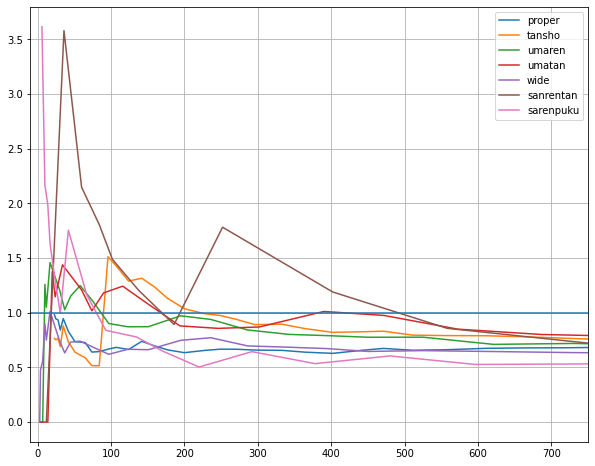

In [34]:
# 横軸: 賭け枚数
# 縦軸: 回収率
# 賭け枚数が少ない→一つの当たりの影響が大きい→賭け枚数が多いところでの期待値も＋になることが理想。

plt.figure(figsize=(10, 8))
plt.plot(g_proper['n_bets'], g_proper['return_rate'], label='proper')
plt.plot(g_tansho['n_bets'], g_tansho['return_rate'], label='tansho')
plt.plot(g_umaren['n_bets'], g_umaren['return_rate'], label='umaren')
plt.plot(g_umatan['n_bets'], g_umatan['return_rate'], label='umatan')
plt.plot(g_wide['n_bets'], g_wide['return_rate'], label='wide')
plt.plot(g_sanrentan['n_bets'], g_sanrentan['return_rate'], label='sanrentan')
plt.plot(g_sanrenpuku['n_bets'], g_sanrenpuku['return_rate'], label='sarenpuku')
plt.hlines(1, xmin=-10, xmax=750) # y=1の直線
plt.xlim(-10, 750)
plt.legend()
plt.grid(True)

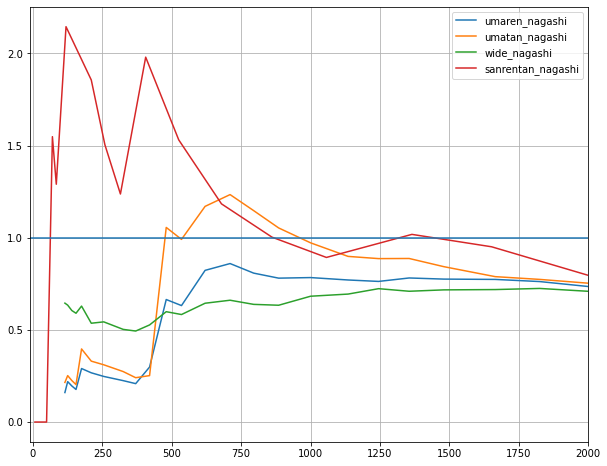

In [35]:
# 横軸: 賭け枚数
# 縦軸: 回収率

plt.figure(figsize=(10, 8))
plt.plot(g_umaren_nagashi['n_bets'], g_umaren_nagashi['return_rate'], label='umaren_nagashi')
plt.plot(g_umatan_nagashi['n_bets'], g_umatan_nagashi['return_rate'], label='umatan_nagashi')
plt.plot(g_wide_nagashi['n_bets'], g_wide_nagashi['return_rate'], label='wide_nagashi')
plt.plot(g_sanrentan_nagashi['n_bets'], g_sanrentan_nagashi['return_rate'], label='sanrentan_nagashi')
plt.hlines(1, xmin=-10, xmax=2000) # y=1の直線
plt.xlim(-10, 2000)
plt.legend()
plt.grid(True)

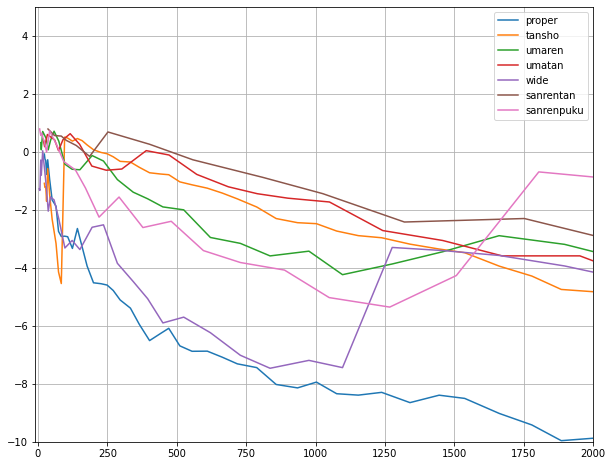

In [40]:
# シャープレシオ

plt.figure(figsize=(10, 8))
plt.plot(g_proper['n_bets'], (g_proper['return_rate'] - 1) / g_proper['std'], label='proper')
plt.plot(g_tansho['n_bets'], (g_tansho['return_rate'] - 1) / g_tansho['std'], label='tansho')
plt.plot(g_umaren['n_bets'], (g_umaren['return_rate'] - 1) / g_umaren['std'], label='umaren')
plt.plot(g_umatan['n_bets'], (g_umatan['return_rate'] - 1) / g_umatan['std'], label='umatan')
plt.plot(g_wide['n_bets'], (g_wide['return_rate'] - 1) / g_wide['std'], label='wide')
plt.plot(g_sanrentan['n_bets'], (g_sanrentan['return_rate'] - 1) / g_sanrentan['std'], label='sanrentan')
plt.plot(g_sanrenpuku['n_bets'], (g_sanrenpuku['return_rate'] - 1) / g_sanrenpuku['std'], label='sanrenpuku')
plt.xlim(-10, 2000)
plt.ylim(-10, 5)
plt.legend()
plt.grid()

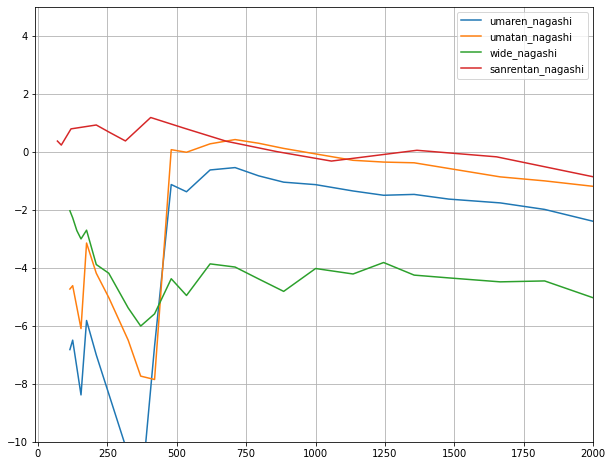

In [37]:
# シャープレシオ

plt.figure(figsize=(10, 8))
plt.plot(g_umaren_nagashi['n_bets'], (g_umaren_nagashi['return_rate'] - 1) / g_umaren_nagashi['std'], label='umaren_nagashi')
plt.plot(g_umatan_nagashi['n_bets'], (g_umatan_nagashi['return_rate'] - 1) / g_umatan_nagashi['std'], label='umatan_nagashi')
plt.plot(g_wide_nagashi['n_bets'], (g_wide_nagashi['return_rate'] - 1) / g_wide_nagashi['std'], label='wide_nagashi')
plt.plot(g_sanrentan_nagashi['n_bets'], (g_sanrentan_nagashi['return_rate'] - 1) / g_sanrentan_nagashi['std'], label='sanrentan_nagashi')
plt.xlim(-10, 2000)
plt.ylim(-10, 5)
plt.legend()
plt.grid()

In [59]:
D = pd.DataFrame(index=[], columns = ["a", "b"])
E = pd.DataFrame(index=[], columns = ["c", "d"])
D.append(E)
D

,a,b
